In [2]:
!pip install -q torch torchvision matplotlib pillow
print("Imports complete. All libraries are ready.")

# --- Imports ---
import os, time, random, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import files as colab_files

# --- Configuration ---
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCHS = 10 # Train for 10 epochs for high accuracy
LR = 1e-3
NUM_CLASSES = 10
IMG_SIZE = 28
MODEL_SAVE_PATH = "my_mnist_model.pth"

# --- Reproducibility ---
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print(f"Using device: {DEVICE}")

Imports complete. All libraries are ready.
Using device: cpu


In [3]:
# --- Data Transforms ---
# For training: add data augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.08, 0.08)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST stats
])

# For testing: just normalize
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# --- Download Datasets ---
train_dataset = datasets.MNIST(
    root='data', train=True, download=True, transform=transform_train
)
test_dataset = datasets.MNIST(
    root='data', train=False, download=True, transform=transform_test
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

print("Data loaded and prepared.")
print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 617kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]

Data loaded and prepared.
Train samples: 60000 | Test samples: 10000


In [4]:
# --- 1. Model Definition ---
class SmallCNN(nn.Module):
    def __init__(self, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)      # -> 14x14
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # features for Grad-CAM
        self.pool2 = nn.MaxPool2d(2,2)      # -> 7x7
        self.fc1   = nn.Linear(128*7*7, 256)
        self.fc2   = nn.Linear(256, NUM_CLASSES)
        self.dropout = nn.Dropout(dropout)
        # Placeholders for Grad-CAM
        self.features = None
        self.gradients = None

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# --- 2. Training Function ---
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

# --- 3. Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

print("Model and helper functions are defined.")

Model and helper functions are defined.


In [11]:
# --- 1. Initialize Model, Loss, Optimizer ---
model = SmallCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"Starting training for {EPOCHS} epochs...")

# --- 2. Training Loop ---
best_acc = 0.0
for ep in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)

    print(f"Epoch {ep}/{EPOCHS} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  -> Saved new best model to {MODEL_SAVE_PATH} (Acc: {best_acc:.4f})")

print(f"\nTraining complete. Best Test Accuracy: {best_acc:.4f}")
print(f"Final model saved to {MODEL_SAVE_PATH}")

In [15]:
# --- 1. Load the Trained Model ---
model = SmallCNN().to(DEVICE)
if not os.path.exists(MODEL_SAVE_PATH):
    raise RuntimeError(f"Model file not found: {MODEL_SAVE_PATH}. Please run Cell 4 first.")

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()
print(f"Loaded model from {MODEL_SAVE_PATH}")

# --- 2. Grad-CAM Hook Functions ---
def save_features_hook(module, input, output):
    model.features = output

def save_gradients_hook(module, grad_input, grad_output):
    model.gradients = grad_output[0]

# --- 3. Register Hooks on conv3 ---
try: # Clear old hooks if any
    handle_f.remove(); handle_b.remove()
except NameError:
    pass

handle_f = model.conv3.register_forward_hook(save_features_hook)
handle_b = model.conv3.register_backward_hook(save_gradients_hook)
print("Grad-CAM hooks registered on 'conv3' layer.")

# --- 4. Grad-CAM Helper Functions ---
def compute_gradcam(inp_tensor, target_class=None):
    logits = model(inp_tensor)
    if target_class is None:
        target_class = int(logits.argmax(dim=1).item())

    model.zero_grad()
    score = logits[0, target_class]
    score.backward()

    fmap = model.features.detach().cpu().numpy()[0]    # C,H,W
    grads = model.gradients.detach().cpu().numpy()[0]  # C,H,W
    weights = grads.mean(axis=(1,2))

    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0) # ReLU
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    if cam.max() != 0:
        cam = cam - cam.min(); cam = cam / (cam.max()+1e-8)
    return cam, target_class

# --- THIS FUNCTION IS MODIFIED ---
def show_img_with_cam(img_tensor, cam, pred, confidence):
    # Un-normalize the tensor for display
    inv = transforms.Normalize(mean=[-0.1307/0.3081], std=[1.0/0.3081])
    img = inv(img_tensor).squeeze().cpu().numpy()

    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)

    # New title with prediction and confidence
    plt.title(f"Grad-CAM Heatmap\nPrediction: {pred} ({confidence:.2f}%)")
    plt.axis('off'); plt.show()

print("Grad-CAM functions are ready.")

Loaded model from my_mnist_model.pth
Grad-CAM hooks registered on 'conv3' layer.
Grad-CAM functions are ready.


Upload a single image file of a digit (0-9).


Saving sample_digit_2_index_1.png to sample_digit_2_index_1 (3).png

--- Prediction: 2 ---
Confidence: 99.99%


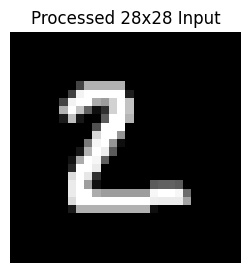

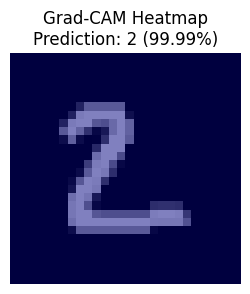

In [16]:
# --- 1. Robust Pre-processing Function ---
def process_image(img_path):
    """
    Loads, processes, and centers a digit from an image.
    Returns a 28x28 PIL Image, ready for the model.
    """
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Invert: model expects white digit on black background
    if img_cv.mean() > 128:
        img_cv = 255 - img_cv

    # Threshold to get a clean binary image
    _ , thr = cv2.threshold(img_cv, 30, 255, cv2.THRESH_BINARY)

    # Find the largest contour (the digit)
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        print("Warning: No contours found. Using whole image.")
        img_digit = thr
        # Get w,h for padding
        h, w = img_digit.shape
    else:
        c = max(cnts, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        img_digit = thr[y:y+h, x:x+w] # Crop to digit

    # --- Create 28x28 Image ---
    # 1. Add padding to preserve aspect ratio
    pad_size = int(max(w,h) * 0.15) # 15% padding
    padded_digit = cv2.copyMakeBorder(
        img_digit, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, value=0
    )

    # 2. Resize to 20x20 (leaves room for centering)
    resized_digit = cv2.resize(padded_digit, (20, 20), interpolation=cv2.INTER_AREA)

    # 3. Center in a 28x28 black image
    final_img_arr = np.zeros((28, 28), dtype=np.uint8)
    final_img_arr[4:24, 4:24] = resized_digit

    # Return as PIL Image (which ToTensor() transform expects)
    return Image.fromarray(final_img_arr)

# --- 2. Upload and Predict ---
print("Upload a single image file of a digit (0-9).")
uploaded = colab_files.upload()

if len(uploaded) == 0:
    print("No file uploaded.")
else:
    fname = list(uploaded.keys())[0]

    # Process the image
    processed_pil_img = process_image(fname)

    # Convert to tensor
    inp_tensor = transform_test(processed_pil_img).unsqueeze(0).to(DEVICE)

    # Run prediction
    with torch.no_grad():
        logits = model(inp_tensor)
        # Apply Softmax to get probabilities
        probs = F.softmax(logits, dim=1)
        # Get the highest probability (confidence) and its class (prediction)
        confidence_tensor, pred_tensor = torch.max(probs, 1)
        prediction = pred_tensor.item()
        confidence_percent = confidence_tensor.item() * 100

    print(f"\n--- Prediction: {prediction} ---")
    print(f"Confidence: {confidence_percent:.2f}%")

    # Show processed image (This has its own title)
    plt.figure(figsize=(3,3))
    plt.imshow(processed_pil_img, cmap='gray')
    plt.title(f"Processed 28x28 Input"); plt.axis('off'); plt.show()

    # Show Grad-CAM (This now has its own title)
    cam, target = compute_gradcam(inp_tensor, target_class=prediction)
    show_img_with_cam(inp_tensor[0], cam, prediction, confidence_percent)